# Community project

Community project to find molecules with activity against B-lactamase which is an enzyme important for bacteria resistance against antibiotics. The project is proposed by Chanin Nantasenamat ([dataprofessor](https://www.youtube.com/channel/UCV8e2g4IWQqK71bbzGDEI4Q)).

In this analisys I re-downloaded the files from ChEMBL and analyzed them since it was difficult to work with the original data. pChEMBL value by its own was not enough to split the data in active and inactive molecules, so after a search in the web I found a preprocessing pipeline that requires some fields not given in the original csv files.

The file called **MERGED_lactamase_community_project.ipynb** is the merge of all the files numbered. The file represents the sequential steps used in the preprocessing. It is my first project of this kind of work and basically, I'm new in cheminformatics and ML, so if you find and error in my preprocessing, I would appreciate you to start and issue.

## Data directly download from ChEMBL

After several try's, I found impossible to train a model with the given data, so I downloaded directly from the ChEMBL. After that, I tried to do the same as with the files given by the Data Profesor, but I did not success too. By reading in literature i found a pipeline where the first split into actives and inactives was given by a particular column called _Comment_.

## Models

Using the pipeline mentioned above I was able to train GNN model. The GNN was implemented with Pytorch Geometric using the ChEMBL files. The GNN model was able to learn at certain point, so in the future I'll posting in this readme the results. Hyperparameter tunning was carried out with Optuna and it was done in two steps:

1- A big search for various parameters

2- Using best parameters of step 1 and and finding parameters for WD and dropout to avoid overfitting.


# Raw data analisys 

As part of the preprocessing, a quick check of the raw data downloaded from ChEMBL is going to be carried out. 

In this section we will analize the difference between the molecules label as actives or inactive in the column "Comment". 

In [1]:
import pandas as pd
pd.options.display.max_columns = None

## Data downloaded from ChEMBL 

As the data presented in the contest did not have all columns. Direct download from ChEMBL was carried out searching for "Beta-lactamase AmpC" as the target. The downloaded file was saved as *molecule_activity* 

In [2]:
df = pd.read_csv('./molecule_activity.csv',sep=';')
df.columns[0:20]

Index(['Molecule ChEMBL ID', 'Molecule Name', 'Molecule Max Phase',
       'Molecular Weight', '#RO5 Violations', 'AlogP', 'Compound Key',
       'Smiles', 'Standard Type', 'Standard Relation', 'Standard Value',
       'Standard Units', 'pChEMBL Value', 'Data Validity Comment', 'Comment',
       'Uo Units', 'Ligand Efficiency BEI', 'Ligand Efficiency LE',
       'Ligand Efficiency LLE', 'Ligand Efficiency SEI'],
      dtype='object')

As we can see, there is a columns called "Comment" which is describes as:

*"Activity comments may provide the overall activity conclusions from the data depositor (e.g. toxic, non-toxic, active, inactive) after taking into account other factors such as counter screens. This can explain cases where compounds with apparently potent activities are flagged as inactive/inconclusive."*

From: https://chembl.gitbook.io/chembl-interface-documentation/frequently-asked-questions/chembl-data-questions

## My interpretation
This tell us that this comments are good source to distinguish between actives and inactives with more presicion.

## Split of the data set into 3 categories: 

The main idea is to subtract from the undefined set, the molecules that are active or inactive not using an arbitrary pChEMBL value cutoff. As I found in some ChEMBL preprocessing pipelines, the column *Comment* is used as a first criteria to split the data, so in this case the comments used were: 

* Actives
* Inactives
* Inconclusive

Papers using this aproach:
<div class="csl-entry">Mayr, A., Klambauer, G., Unterthiner, T., Steijaert, M., Wegner, J. K., Ceulemans, H., Clevert, D. A., &#38; Hochreiter, S. (2018). Large-scale comparison of machine learning methods for drug target prediction on ChEMBL. <i>Chemical Science</i>, <i>9</i>(24), 5441–5451. https://doi.org/10.1039/C8SC00148K</div>

In [this paper](https://f1000researchdata.s3.amazonaws.com/manuscripts/15276/9c9a53a2-9a80-4223-bc8d-67aee14df227_11905_-_sereina_riniker_v2.pdf?doi=10.12688/f1000research.11905.2&numberOfBrowsableCollections=29&numberOfBrowsableInstitutionalCollections=4&numberOfBrowsableGateways=31) the autors did not use the ambiguos results of the HTS study.

https://f1000researchdata.s3.amazonaws.com/manuscripts/15276/9c9a53a2-9a80-4223-bc8d-67aee14df227_11905_-_sereina_riniker_v2.pdf?doi=10.12688/f1000research.11905.2&numberOfBrowsableCollections=29&numberOfBrowsableInstitutionalCollections=4&numberOfBrowsableGateways=31


In [3]:
df.Comment.value_counts().head(10)

Inconclusive               52677
Not Active                  8951
Active                       165
Not Determined                 7
Not applicable                 4
Hydrolysis not detected        2
324165                         1
324147                         1
324209                         1
324191                         1
Name: Comment, dtype: int64

As we can see, the most repeated values are Inconclusive, Not active, and Active ones. The rest of the values are going to be deleted from the data set since they are ambiguous. 
First, we are going to analysis the values of the actives and inactive in the same data frame. 

In [4]:
df_inconclusive = df[(df.Comment == 'Inconclusive')]
df_act_inac = df[(df.Comment == 'Active') | (df.Comment == 'Not Active')]

## pChEMBL value in the active and inactive sets
As the value of the pChEMBL was proposed as the main distintion for active molecules and inactives, it would be pertinet to actually check if it is a good idea.

In [6]:
# By counts
df_count = df_act_inac.groupby(['Standard Type', 'Comment']).count()[['pChEMBL Value', 'Standard Value']]
# By mean
df_mean = df_act_inac.groupby(['Standard Type', 'Comment']).mean()[['pChEMBL Value', 'Standard Value']]
# By std
df_std = df_act_inac.groupby(['Standard Type', 'Comment']).std()[['pChEMBL Value', 'Standard Value']]

### Count grouping by 'Standard Type' and 'Comment'

In [7]:
df_count

pChEMBL Value  Standard Value
Standard Type Comment                                  
IC50          Not Active              0               0
Inhibition    Not Active              0               0
Ki            Active                  8               8
No change     Not Active              0               0
Potency       Active                157             157
              Not Active           8886            8886

Active/Inactive molecules are only present in the Potency Standard value, which is a general representation of the activity. It would be desirable build a dataset based only in one ST but only potency is available. There are also active molecules for the Ki ST but are only 8. Those will be considered in the dataset. 

### Mean grouping by 'Standard Type' and 'Comment'

In [13]:
df_mean

pChEMBL Value  Standard Value
Standard Type Comment                                  
IC50          Not Active            NaN             NaN
Inhibition    Not Active            NaN             NaN
Ki            Active           4.895000    13500.000000
No change     Not Active            NaN             NaN
Potency       Active           4.601975    37869.515924
              Not Active       4.978202    37462.626052

This part goes interesting, since the mean value in both datasets have very similar pChEMBL values for the active and inactive molecules, but what is weird is that the mean of inactive molecules is higher than the mean of active ones. That means that pChEMBL value is not that reliable to distinguish between actives and inactives. To make this more visual, there will be presented the histogram for the pChEMBL value for each dataset. 

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

df_act = df_act_inac[df_act_inac['Comment'] == 'Active']
df_inact = df_act_inac[df_act_inac['Comment'] == 'Not Active']

df_act_counts = df_act.groupby('pChEMBL Value', as_index = False).count()[['pChEMBL Value', 'Smiles']]
df_inact_counts = df_inact.groupby('pChEMBL Value', as_index = False).count()[['pChEMBL Value', 'Smiles']]
df_act_counts.columns = ['pChEMBL Value', 'Relative Count']
df_inact_counts.columns = ['pChEMBL Value', 'Relative Count']

# Standarizing
df_act_counts['Relative Count'] = (df_act_counts['Relative Count'] / df_act_counts['Relative Count'].sum()) * 100
df_inact_counts['Relative Count'] = (df_inact_counts['Relative Count'] / df_inact_counts['Relative Count'].sum()) * 100

#### Actives

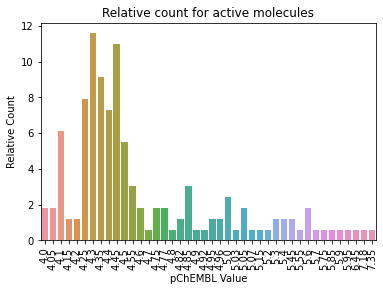

In [9]:
sns.barplot(x = df_act_counts['pChEMBL Value'], y = df_act_counts['Relative Count'])
plt.xticks(rotation=90)
plt.title('Relative count for active molecules')
plt.show()

Text(0.5, 1.0, 'Counts for active molecules')

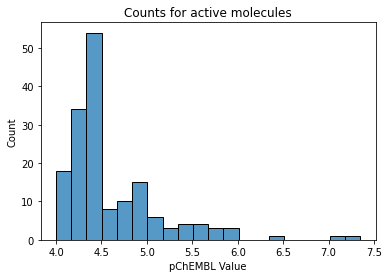

In [10]:
sns.histplot(df_act['pChEMBL Value'], bins=20)
plt.title('Counts for active molecules')

Its important to note that a big quantity of the pChEMBL values for active molecules are low, being almost half of the records between 4.25 and 5.0.

#### Inactives

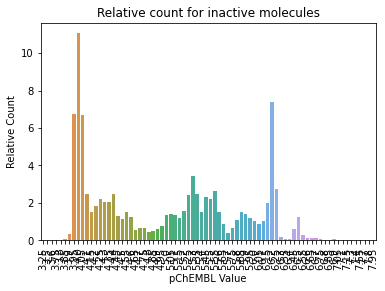

In [11]:
sns.barplot(x = df_inact_counts['pChEMBL Value'], y = df_inact_counts['Relative Count'])
plt.xticks(rotation=90)
plt.title('Relative count for inactive molecules')
plt.show()

Text(0.5, 1.0, 'Counts for inactive molecules')

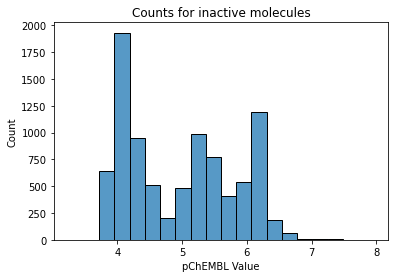

In [12]:
sns.histplot(df_inact['pChEMBL Value'], bins=20)
plt.title('Counts for inactive molecules')


Also the inactives molecules have many molecules with high pChEMBL value.

#### Inconclusive

Text(0.5, 1.0, 'Counts for inconclusive molecules')

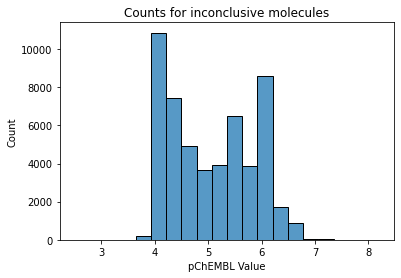

In [13]:
sns.histplot(df_inconclusive['pChEMBL Value'], bins=20)
plt.title('Counts for inconclusive molecules')

In the inconclusive values, there is not clear bias in the pChEMBL value, that is ok, since it represents a pool of possible active/inactive values. 
As a conclusion, there is not clear difference in pChEMBL value between active and inactive molecules since all distributions looks centered. 

### Std grouping by 'Standard Type' and 'Comment'

In [14]:
df_std

pChEMBL Value  Standard Value
Standard Type Comment                                  
IC50          Not Active            NaN             NaN
Inhibition    Not Active            NaN             NaN
Ki            Active           0.178646     4140.393356
No change     Not Active            NaN             NaN
Potency       Active           0.550129    23917.411609
              Not Active       0.849518    42650.491602

## Saving the dataframes in different csv files

First, we are going to select the columns that are going to be usefull in the future

In [26]:
columns = ['Smiles', 'Standard Type', 'Standard Relation', 'Standard Value', 'Standard Units', 'pChEMBL Value', 'BAO Label', 'Target Name']
columns_desired_name = ['Smiles', 'Standard_Type', 'Standard_Relation', 'Standard_Value', 'Standard_Units', 'pChEMBL_Value', 'BAO_Label', 'Target_Name']

df_act = df_act[columns]
df_inact = df_inact[columns]
df_inconclusive = df_inconclusive[columns]

df_act.columns = columns_desired_name
df_inact.columns = columns_desired_name
df_inconclusive.columns = columns_desired_name

Now we save the dataframes in diferent files

In [17]:
df_act.to_csv('./actives.csv', index=False)
df_inact.to_csv('./inactives.csv', index=False)
df_inconclusive.to_csv('./inconclusive.csv', index=False)

## Analyzing some molecule properties between molecules datasets

Part of the code was taken from the book: 
* Bharath Ramsundar, Peter Eastman, Patrick Walters, Vijay Pande - Deep Learning for the Life Sciences_ Applying Deep Learning to Genomics, Microscopy, Drug Discovery, and More-O’Reilly Media (2019)

In [29]:
from rdkit import Chem # RDKit libraries for chemistry functions
from rdkit.Chem import Draw # Drawing chemical structures
import pandas as pd # Dealing with data in tables
from rdkit.Chem import PandasTools # Manipulating chemical data
from rdkit.Chem import Descriptors # Calculating molecular descriptors
from rdkit.Chem import rdmolops # Additional molecular properties
import seaborn as sns # Making graphs 
import numpy as np

%matplotlib inline

In [27]:
df_act = df_act[['Smiles', 'pChEMBL_Value']]
df_inact = df_inact[['Smiles', 'pChEMBL_Value']]
df_inconclusive = df_inconclusive[['Smiles', 'pChEMBL_Value']]

In [32]:
def molFromSmiles(smiles):
    if isinstance(smiles, str):
        return Chem.MolFromSmiles(smiles)
    else:
        return False
    
def wtFromMol(mol):
    if mol:
        return Descriptors.MolWt(mol)
    else:
        return 0
    
def MolLogP(mol):
    if mol:
        return Descriptors.MolLogP(mol)
    else:
        return 0
    
def GetFormalCharge(mol):
    if mol:
        return rdmolops.GetFormalCharge(mol)
    else:
        return 0

def add_property_columns_to_df(df_in):
    df_in['MW'] = [wtFromMol(molFromSmiles(smiles)) for smiles in df_in.Smiles]
    df_in["logP"] = [MolLogP(molFromSmiles(smiles)) for smiles in df_in.Smiles]
    df_in["charge"] = [GetFormalCharge(molFromSmiles(smiles)) for smiles in df_in.Smiles]


In [33]:
add_property_columns_to_df(df_act)
add_property_columns_to_df(df_inact)
add_property_columns_to_df(df_inconclusive)

In [36]:
df_act = df_act.assign(status='Active')
df_inact = df_inact.assign(status='Inactive')

df_act_inac = pd.concat([df_act, df_inact]).sample(frac=1).sample(frac=1).sample(frac=1)

/home/alfilalex/miniconda3/envs/torchrdkit/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='status', ylabel='MW'>

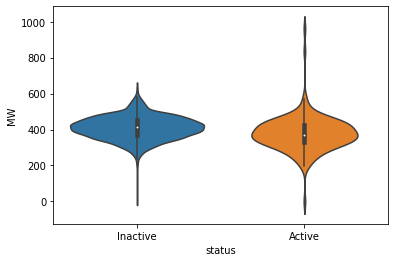

In [37]:
sns.violinplot(df_act_inac["status"],df_act_inac["MW"])

/home/alfilalex/miniconda3/envs/torchrdkit/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='status', ylabel='logP'>

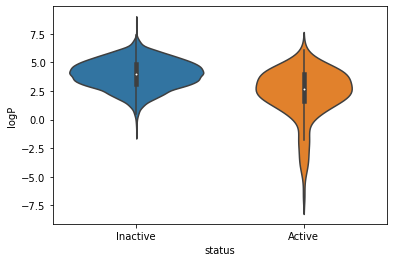

In [38]:
sns.violinplot(df_act_inac["status"],df_act_inac["logP"])

/home/alfilalex/miniconda3/envs/torchrdkit/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='status', ylabel='charge'>

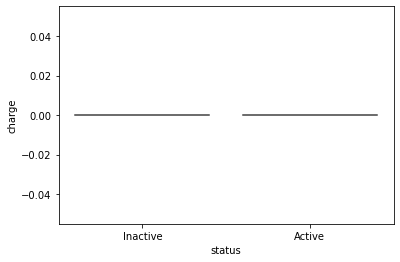

In [39]:
sns.violinplot(df_act_inac["status"],df_act_inac["charge"])

Molecule properties will be revised again at the end of the preprocess